In [1]:
import math

import numpy as np
from matplotlib.pyplot import plot, show, xlabel, ylabel, suptitle
from pandas import DataFrame, read_csv, to_datetime, concat
from sklearn.metrics import r2_score, mean_poisson_deviance, mean_squared_error, mean_absolute_error
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV


class FlightDelayPredictor:
    """
     A b regression prediction class
     contains the blue print of a prediction class
     """
    date_time_fields = ['Scheduled depature time', 'Scheduled arrival time']
    categorical_variables = ['Depature Airport', 'Destination Airport']

    def __init__(self, path_to_dataset_csv):
        """
        Initialises dataset from dataset from data frame
        Uses the last column as Y and the others as X
        and calls the split function from subclass if defined
        :param path_to_dataset_csv:
        """
        self.dataset: DataFrame = read_csv(path_to_dataset_csv)
        self.X = self.dataset.iloc[:, :-1]
        self.Y = self.dataset.iloc[:, -1]
        self.pre_process_data()
        self.X_train, self.X_test, self.Y_train, self.Y_test = self.split_dataset()

    def pre_process_data(self):
        """
        performs pre-processing on the data set namely
        1.Extract more features from timestamp,->year, month, day, day_of_week
        2. Label encode categorical features
        3. Add feature flight duration
        4. handle missing data
        :return:
        """
        self.declare_datetime_fields()
        self.add_flight_duration_column()
        self.expand_datetime_fields()
        self.label_encode_categorical_variables()
        self.handle_missing_values()

    def remove_outliers(self):
        lof = LocalOutlierFactor(n_neighbors=10)
        outlier_prediction = lof.fit_predict(self.X_train)
        X_Y_train = concat([self.X_train, self.Y_train], axis=1)
        X_Y_train['outlier_prediction'] = outlier_prediction
        inliers = X_Y_train.query('outlier_prediction == 1').copy(deep=False)
        inliers.drop('outlier_prediction', inplace=True, axis=1)
        self.X_train, self.Y_train = inliers.iloc[:, :-1], inliers.iloc[:, -1]

    def handle_missing_values(self, ):
        self.X = self.X.interpolate(method='ffill', limit_direction='forward')

    def label_encode_categorical_variables(self):
        label_encoder = LabelEncoder()
        for field in self.categorical_variables:
            self.X[field] = label_encoder.fit_transform(self.X[field])

    def add_flight_duration_column(self):
        """
        Add Flight Duration Field
        :return:
        """
        self.X['flight_duration_hours'] = (self.X['Scheduled arrival time'] - self.X[
            'Scheduled depature time']) / np.timedelta64(1, 'h')

    def expand_datetime_fields(self):
        """
        expands  date_time field into, year, month, day, day_of_week
        :return:
        """
        for field in self.date_time_fields:
            prefix = field.split(" ")[1]
            self.X[f'{prefix}_year'] = self.X[field].dt.year
            self.X[f'{prefix}_month'] = self.X[field].dt.month
            self.X[f'{prefix}_day'] = self.X[field].dt.day
            self.X[f'{prefix}_day_of_week'] = self.X[field].dt.weekday

    def drop_date_time_fields(self, dataset):
        for field in self.date_time_fields:
            dataset.drop(field, inplace=True, axis=1)

    def declare_datetime_fields(self):
        """
        change datetime fields from string to datetime types
        :return:
        """
        for field in self.date_time_fields:
            self.X[field] = to_datetime(self.X[field])

    def split_dataset(self) -> tuple:
        """
         overrides the base split_dataset method and Split to train_test based on
         Scheduled departure time, train with year 2015-2017, test with 2018
        :return:
        """
        self.dataset = concat([self.X, self.Y], axis=1)
        dataset_train = self.dataset.query('depature_year < 2018').copy(deep=False)
        dataset_test = self.dataset.query('depature_year >= 2018').copy(deep=False)
        self.drop_date_time_fields(dataset_train)
        self.drop_date_time_fields(dataset_test)
        X_train = dataset_train.iloc[:, :-1]
        Y_train = dataset_train.iloc[:, -1]

        X_test = dataset_test.iloc[:, :-1]
        Y_test = dataset_test.iloc[:, -1]

        return X_train, X_test, Y_train, Y_test

    def visualize(self):
        """
        Plots the flight duration x against y
        :return:
        """
        xlabel('Flight Duration(hours)', fontsize=18)
        ylabel('Delay (minutes)', fontsize=16)
        suptitle('Flight Delay Visualization')
        plot(self.X_train['flight_duration_hours'], self.Y_train, marker='.')
        show()

    def train_model(self, model_class, *args, **kwargs):
        """
        Takes a sci-kit learn model class and arguments and fits it on the train set
        :param model_class:
        :param args:
        :param kwargs:
        :return: Trained model
        """
        model = model_class(*args, **kwargs)
        model.fit(self.X_train, self.Y_train)
        return model

    def get_best_parameters(self, model_class, param_grid):
        """
        Performs Cross Validation and returns a grid search result of best parameter
        :param model_class:
        :param param_grid:
        :return:
        """
        CV_rfc = GridSearchCV(estimator=model_class(), param_grid=param_grid, cv=10)
        CV_rfc.fit(self.X_train, self.Y_train)
        return CV_rfc.best_params_

    def evaluate_model(self, trained_model, X_test=None, Y_test=None):
        """
        Evaluates A trained model and measures its accuracy
        :param trained_model:
        :param X_test:
        :param Y_test:
        :return: Accuracy Measures
        """
        X_test = self.X_test if X_test is None else X_test
        Y_test = self.Y_test if Y_test is None else Y_test

        predictions = trained_model.predict(X_test)
        return {
            'mean_absolute_error': mean_absolute_error(Y_test, predictions),
            'mean_squared_error': mean_squared_error(Y_test, predictions),
            'root_mean_squared_error': math.sqrt(mean_squared_error(Y_test, predictions)),
            'r2_score': r2_score(Y_test, predictions),
        }



predictor = FlightDelayPredictor('./flight_delay.csv')


### Visualize

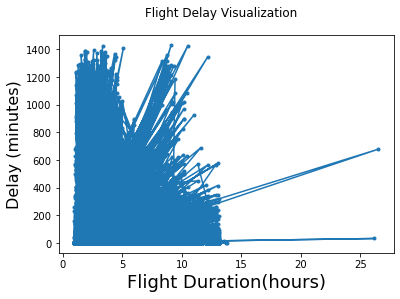

In [2]:
predictor.visualize()

### Remove Outliers

In [3]:
predictor.remove_outliers()

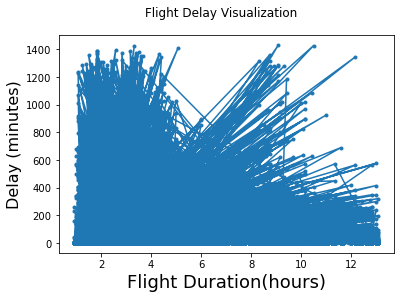

In [4]:
predictor.visualize()

### Import Models

In [5]:
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neural_network import MLPRegressor

In [7]:
models_param_grid = [
    (LinearRegression, {}),
    (Lasso, {"alpha": [x * 0.1 for x in range(10, 50,10)]}),

    (Ridge, {"alpha": [x * 0.1 for x in range(10, 50,10)]}),

    (ElasticNet, {"alpha": [x * 0.1 for x in range(10, 100,10)], 'l1_ratio': [x * 0.1 for x in range(1, 10)], }),

    (AdaBoostRegressor, {'n_estimators': [50, 100, 500], "loss": ['linear', 'square', 'exponential'], }),

    (GradientBoostingRegressor,{'n_estimators': [50, 100, 200,]}),

]


### Cross Validate And Get Best Hyper Parameters

In [9]:
best_params = []
for  model_class, parameter_grid in models_param_grid:
    best_params.append(predictor.get_best_parameters(model_class, parameter_grid ))
best_params

[{}, {}, {}, {}, {}, {}]

In [10]:
models = [model for model,parameter_grid in models_param_grid]
models_best_params = list(zip(models,best_params))

### Train Models

In [11]:
trained_models = []
for model,best_params in models_best_params:
    print(f"Training {model}")
    trained_models.append(predictor.train_model(model,**best_params))
    print(f"Trained {model}")
  

Training <class 'sklearn.linear_model._base.LinearRegression'>
Trained <class 'sklearn.linear_model._base.LinearRegression'>
Training <class 'sklearn.linear_model._coordinate_descent.Lasso'>
Trained <class 'sklearn.linear_model._coordinate_descent.Lasso'>
Training <class 'sklearn.linear_model._ridge.Ridge'>
Trained <class 'sklearn.linear_model._ridge.Ridge'>
Training <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
Trained <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
Training <class 'sklearn.ensemble._weight_boosting.AdaBoostRegressor'>
Trained <class 'sklearn.ensemble._weight_boosting.AdaBoostRegressor'>
Training <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
Trained <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>


## Evaluate with Training Set

In [14]:
training_evaluation = []
for model in trained_models:
    scores = predictor.evaluate_model(model,predictor.X_train,predictor.Y_train)
    training_evaluation.append({"model":type(model).__name__,**scores})
DataFrame(training_evaluation)    

,model,mean_absolute_error,mean_squared_error,root_mean_squared_error,r2_score
0,LinearRegression,15.464568,2163.760247,46.516236,0.004261
1,Lasso,15.505549,2166.233130,46.542810,0.003123
2,Ridge,15.467819,2164.337253,46.522438,0.003996
3,ElasticNet,15.499584,2165.951097,46.539780,0.003253
4,AdaBoostRegressor,40.206180,3638.746253,60.322021,-0.674511
5,GradientBoostingRegressor,15.086348,2123.097238,46.077079,0.022974


## Evaluate with Test Set

In [15]:
evaluation = []
for model in trained_models:
    scores = predictor.evaluate_model(model)
    evaluation.append({"model":type(model).__name__,**scores})

DataFrame(evaluation)  

,model,mean_absolute_error,mean_squared_error,root_mean_squared_error,r2_score
0,LinearRegression,16.226042,1645.142699,40.560359,-0.026436
1,Lasso,14.413525,1617.204138,40.214477,-0.009005
2,Ridge,16.212315,1644.282827,40.549757,-0.025900
3,ElasticNet,14.464057,1618.206086,40.226932,-0.009630
4,AdaBoostRegressor,46.043944,3888.984535,62.361723,-1.426412
5,GradientBoostingRegressor,14.999207,1628.847301,40.358980,-0.016269
